In [ ]:
import sys

import os

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
latent_dims = 200
num_epochs = 300
batch_size = 128
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True


In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_ds = torch.utils.data.Subset(train_dataset, range(0, 60000))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_ds = torch.utils.data.Subset(test_dataset, range(0, 60000))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        linear_out = 1024
        linear_out1 = 512
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.linear1 = nn.Linear(c*2*7*7,out_features = linear_out)
        self.linear2 = nn.Linear(linear_out,out_features = linear_out1)
        self.fc_mu = nn.Linear(in_features=linear_out1, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=linear_out1, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) 
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        linear_out = 1024
        linear_out1 = 512
        self.linear1 = nn.Linear(in_features=latent_dims, out_features = linear_out)
        self.linear2 = nn.Linear(in_features=linear_out, out_features = linear_out1)
        self.fc = nn.Linear(in_features = linear_out1, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.fc(F.relu(self.linear2(x)))
        x = x.view(x.size(0), capacity*2, 7, 7) 
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) 
        return x
    
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def vae_loss(recon_x, x, mu, logvar):
    
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    

    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + variational_beta * kldivergence
    
    
vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
print(device)
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

cuda:0
Number of parameters: 10960261


In [ ]:
print(vae)

VariationalAutoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (linear1): Linear(in_features=6272, out_features=1024, bias=True)
    (linear2): Linear(in_features=1024, out_features=512, bias=True)
    (fc_mu): Linear(in_features=512, out_features=2, bias=True)
    (fc_logvar): Linear(in_features=512, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=2, out_features=1024, bias=True)
    (linear2): Linear(in_features=1024, out_features=512, bias=True)
    (fc): Linear(in_features=512, out_features=6272, bias=True)
    (conv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv1): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)


In [ ]:

learning_rate = 0.0001

optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)


vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
  
    
    for image_batch, _ in train_dataloader:
        
        image_batch = image_batch.to(device)

       
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        
       
        optimizer.zero_grad()
        loss.backward()
        
        
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        
        
    train_loss_avg[-1] /= len(train_dataloader.dataset)
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 100] average reconstruction error: 206.245940
Epoch [2 / 100] average reconstruction error: 167.965755
Epoch [3 / 100] average reconstruction error: 159.881240
Epoch [4 / 100] average reconstruction error: 155.783843
Epoch [5 / 100] average reconstruction error: 153.390609
Epoch [6 / 100] average reconstruction error: 151.637295
Epoch [7 / 100] average reconstruction error: 150.204192
Epoch [8 / 100] average reconstruction error: 148.990733
Epoch [9 / 100] average reconstruction error: 147.849541
Epoch [10 / 100] average reconstruction error: 146.858760
Epoch [11 / 100] average reconstruction error: 145.973002
Epoch [12 / 100] average reconstruction error: 145.256375
Epoch [13 / 100] average reconstruction error: 144.551950
Epoch [14 / 100] average reconstruction error: 143.930487
Epoch [15 / 100] average reconstruction error: 143.380380
Epoch [16 / 100] average reconstruction error: 142.787652
Epoch [17 / 100] average reconstruction error: 142.276253
Epoch [18 

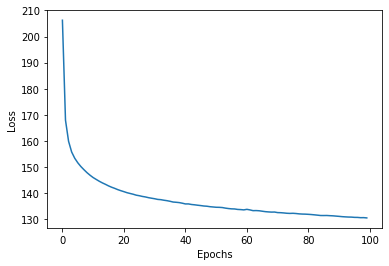

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.legend()
plt.show()

Original images


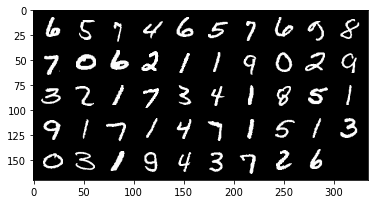

VAE reconstruction:


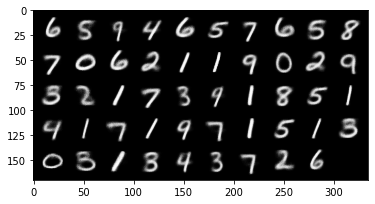

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()


def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()


print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()


print('VAE reconstruction:')
visualise_output(images, vae)

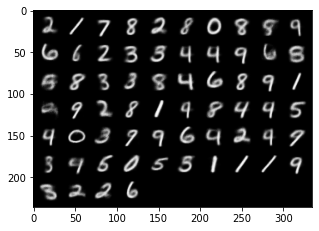

In [ ]:
vae.eval()

with torch.no_grad():

    
    latent = torch.randn(64, latent_dims).to(device)

   
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()
    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

In [ ]:
torch.save(vae.state_dict(), '/vae.pth')